# Solving the 1D Poisson Equation Using Physics-Informed Neural Networks (PINNs)

## Problem Statement

The **1D Poisson equation** is a fundamental partial differential equation (PDE) that appears in various areas of physics and engineering, including **electrostatics**, **heat conduction**, and **mechanical deformation**.

In its general form, the equation is:

$$
\frac{d^2u(x)}{dx^2} = -\,f(x), \quad x \in (0, 1)
$$

Where:  
- $u(x)$ is the unknown function (e.g., electric potential or temperature),  
- $f(x)$ is a prescribed source function (e.g., charge density or heat source),  
- The domain is one-dimensional: $x \in [0, 1]$.

---

## Gaussian (Localized) Source

For this example we choose a **localized Gaussian source**:

$$
f(x) = A \exp\!\Bigl(-\frac{(x - x_0)^2}{2\,\sigma^2}\Bigr),
$$

with typical parameter values  
- $A = 1.0$  
- $x_0 = 0.5$  
- $\sigma = 0.1$  

This models a “hot spot” or concentrated load centered at $x_0$, and tests how well the PINN captures sharp spatial variations.

---

## Boundary Conditions

To obtain a well-posed problem, we impose **Dirichlet boundary conditions**:

$$
u(0) = 0, \quad u(1) = 0
$$

This corresponds to a rod with both ends held at zero temperature (or a grounded wire).

---

## Analytical Solution

The exact solution of

$$
u''(x) + f(x) = 0,\quad u(0)=u(1)=0,
$$

with $f(x)=A\exp\bigl(-\tfrac{(x-x_0)^2}{2\sigma^2}\bigr)$ can be written in terms of the Green’s function

$$
G(x,s)=
\begin{cases}
s\,(1 - x), & s \le x,\\
x\,(1 - s), & s > x,
\end{cases}
$$

as the integral

$$
\boxed{
u_{\rm exact}(x)
=
\int_{0}^{1} G(x,s)\,f(s)\,\mathrm{d}s
=
A\Bigl[\,
(1 - x)\!\!\int_{0}^{x} s\,e^{-\frac{(s-x_0)^2}{2\sigma^2}}\,ds
\;+\;
x\!\int_{x}^{1}(1 - s)\,e^{-\frac{(s-x_0)^2}{2\sigma^2}}\,ds
\Bigr].
}
$$

In practice this is evaluated numerically (e.g., via the trapezoidal rule) to produce an “analytical” reference curve.

---

## PINN Objective

We aim to approximate $u(x)$ by training a neural network to minimize the combined loss

$$
\mathcal{L} = \underbrace{\mathrm{MSE}_{\mathrm{res}}}_{\text{PDE residual}} \;+\; \underbrace{\mathrm{MSE}_{\mathrm{bc}}}_{\text{boundary conditions}}.
$$

Here,

- $$\mathrm{MSE}_{\mathrm{res}} = \frac{1}{N_r} \sum_{i=1}^{N_r} \Bigl(u_{xx}(x_i) + A \exp\bigl(-\tfrac{(x_i - x_0)^2}{2\sigma^2}\bigr)\Bigr)^2,$$  
- $$\mathrm{MSE}_{\mathrm{bc}} = \bigl(u(0) - 0\bigr)^2 + \bigl(u(1) - 0\bigr)^2.$$

where $u_{xx}(x_i)$ is the second derivative of the network’s prediction at the residual points $x_i$.

---

## Why Use PINNs?

Traditional methods (finite difference, finite element) require meshing and can struggle with sharp localized features. PINNs:

- **Encode the PDE directly** into the loss  
- Are **mesh-free** and flexible  
- Can **resolve sharp gradients** without special mesh refinement  

Let’s now build and train our PINN to tackle this Gaussian-source Poisson problem!


In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
def pde(x, x0, A, sigma, network):
    x = x.clone().detach().requires_grad_(True)

    u = network(x)   # Network Prediction
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]   # First Derivative
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]   # Second Derivative

    source = A * torch.exp(-(x - x0)**2/(2 * sigma**2))

    return u_xx + source

In [14]:
def loss(network, x, x0, x_bc, y_bc, A, sigma):
    res = pde(x, x0, A, sigma, network)
    MSE_res = torch.mean(res**2)

    y_bc_pred = network(x_bc)
    MSE_bc = torch.mean((y_bc_pred - y_bc)**2)

    return MSE_res + MSE_bc

In [15]:
def train(network, x, x0, x_bc, y_bc, A, sigma, epochs, lr = 1e-3):
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    loss_list = []

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        loss_value = loss(network, x, x0, x_bc, y_bc, A, sigma)
        loss_list.append(loss_value.item())
        loss_value.backward()
        optimizer.step()

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} — Loss: {loss_value.item():.3e}")

    return loss_list

In [16]:
# Collocation points in the interior
x_train = np.linspace(0, 1, 5000).reshape(-1,1)
x_train = torch.tensor(x_train, dtype=torch.float32)

# Gaussian source parameters
A = 1.0
x0 = 0.5
sigma = 0.1

# Boundary‐condition points and values
x_bc = torch.tensor([[0.0], [1.0]], dtype=torch.float32)   # x=0 and x=1
y_bc = torch.tensor([[0.0], [0.0]], dtype=torch.float32)   # u(0)=0 and u(1)=0

# Training hyperparameters
epochs = 2500
lr = 1e-3

#  Instantiate and train the model
model = NeuralNetwork()
loss_list = train(model, x_train, x0, x_bc, y_bc, A, sigma, epochs, lr)


Epoch 1/2500 — Loss: 1.635e-01
Epoch 100/2500 — Loss: 3.926e-03
Epoch 200/2500 — Loss: 3.907e-04
Epoch 300/2500 — Loss: 2.185e-04
Epoch 400/2500 — Loss: 9.738e-05
Epoch 500/2500 — Loss: 2.890e-05
Epoch 600/2500 — Loss: 4.314e-05
Epoch 700/2500 — Loss: 3.623e-06
Epoch 800/2500 — Loss: 2.471e-06
Epoch 900/2500 — Loss: 6.209e-06
Epoch 1000/2500 — Loss: 2.341e-06
Epoch 1100/2500 — Loss: 2.272e-06
Epoch 1200/2500 — Loss: 2.638e-06
Epoch 1300/2500 — Loss: 2.253e-06
Epoch 1400/2500 — Loss: 2.185e-06
Epoch 1500/2500 — Loss: 2.297e-06
Epoch 1600/2500 — Loss: 2.939e-06
Epoch 1700/2500 — Loss: 5.682e-04
Epoch 1800/2500 — Loss: 2.177e-06
Epoch 1900/2500 — Loss: 2.088e-06
Epoch 2000/2500 — Loss: 2.955e-06
Epoch 2100/2500 — Loss: 2.093e-06
Epoch 2200/2500 — Loss: 6.125e-06
Epoch 2300/2500 — Loss: 4.824e-05
Epoch 2400/2500 — Loss: 2.079e-06
Epoch 2500/2500 — Loss: 1.975e-06


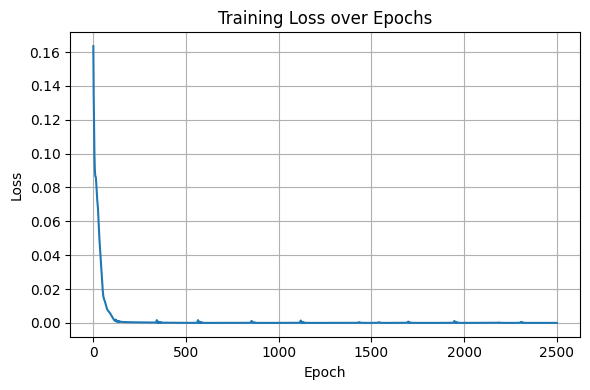

In [17]:
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

### Testing the model

In [18]:
def analytical_u(x_vals, A, x0, sigma):
    s = np.linspace(0, 1, 2001)
    f_s = A * np.exp(-(s - x0)**2 / (2 * sigma**2))
    u_vals = []
    
    for xi in x_vals:
        mask1 = s <= xi
        mask2 = s >= xi
        I1 = np.trapz((1 - xi) * s[mask1] * f_s[mask1], s[mask1])
        I2 = np.trapz(xi * (1 - s[mask2]) * f_s[mask2], s[mask2])
        u_vals.append(I1 + I2)

    return np.array(u_vals)

In [19]:
x_test = np.linspace(0, 1, 1000).reshape(-1,1)
x_test = torch.tensor(x_test, dtype=torch.float32)

model.eval()

with torch.no_grad():
    y_pred = model(x_test)

y_pred_np = y_pred.cpu().numpy()

# Analytical Solution
x_test_np = x_test.cpu().numpy().flatten()
y_true = analytical_u(x_test_np, A, x0, sigma)

/tmp/ipykernel_13123/3319267873.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I1 = np.trapz((1 - xi) * s[mask1] * f_s[mask1], s[mask1])
/tmp/ipykernel_13123/3319267873.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I2 = np.trapz(xi * (1 - s[mask2]) * f_s[mask2], s[mask2])


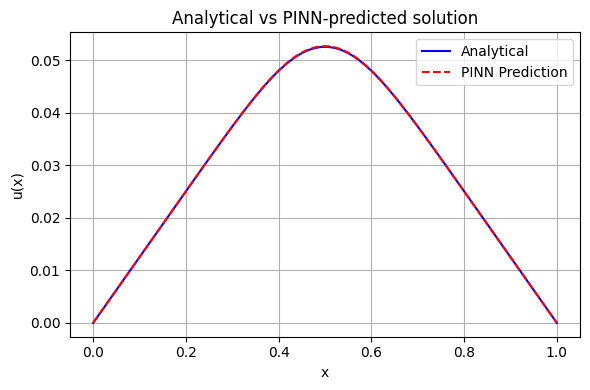

In [20]:
# Plot the Results
plt.figure(figsize=(6,4))

plt.plot(x_test, y_true, 'b-', label='Analytical')
plt.plot(x_test, y_pred_np, 'r--', label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Analytical vs PINN‐predicted solution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()